In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.stats as stats
import matplotlib.pyplot as plt
import umap
import pickle
import time
import xgboost

from sklearn import linear_model, model_selection, metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as GDA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score as RAS
from sklearn.metrics import roc_curve as ROC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNC

```bash
jupyter nbconvert --output-dir='./tex' --to latex "ETHANWALKER-404-FinalProject.ipynb" --TagRemovePreprocessor.remove_input_tags='{"hide_input"}'; pdflatex tex/ETHANWALKER-404-FinalProject
```

# Abstract
Machine Learning is becomeing a more prevelant tool in the world of criminal justice. Often it is used to predict who will commit a crime or where crimes may occur. Seldom is it used to regulate the criminal justice system, however. In this project I examine prison inmate data and determine what machine learning techniques are effective at detecting the racial bias that has been shown to exist in this data. In this report I find ---------

# Problem Statement and Motivation
Last semester I took a look a data set containing the information of more than 7.5 million individuals that have been processed by the criminal justice system. I found that racial minorities were more likely to receive extreme sentences, agreeing with existing research around bias in the criminal justice system. In this project I will be exploring the data from a machine learning perspective. My goal is to determine if this data can be classified in such a way that is predictive of race. The idea is that perhaps racial bias can be detected in various systems by seeing how effective different machine learning techniques are at classifying an inmate's by race given their data.

This is an unconventional way to approach criminal justice data with machine learning. Often we see machine learning being used to attempt to determine who might be a criminal or where crimal activity may occur using social media data and other public information, which may include data the government owns, but which is not available to te public. These approaches often ignore or discount the ways that these techniques may disproportionately affect people of color and the poor. Many organizations have made official statements reguarding the use of machine learning in this way, often called predicitive policing. The ACLU for example released a statement listing civil rights related concerns about predicitive policing which was signed by several civil rights origanizations includeing the NAACP [[1]](https://www.aclu.org/other/statement-concern-about-predictive-policing-aclu-and-16-civil-rights-privacy-racial-justice).

My objective is to go against the predictive policing paradigm and use machine learning to benefit these negatively affected classes of people by using machine learning as a diagnostic tool. If it can be shown that certain machine learning techniques are effective at classifying inmates by race given incarceration related information, then we can inform policies that will attempt to correct for these systemic racial biases. 

# Data
## Source and Credibility
The data that I will be using in this analysis is from one source. It is a [database](https://catalog.data.gov/dataset/sentenced-inmates-in-correctional-facilities) hosted on [Data.gov](https://www.data.gov) and maintained by the State of Connecticut Department of Corrections. This source is highly credible because it is a primary source for the data. This organization is an official government agency which collects, maintains, and reports on this data.

## Gathering and Cleaning
All the data which I am using in this report are freely available to the public. Collection and cleaning was relatively simple as the source data was well maintained. The file that I obtained from the Connecticut Department of Corrections is a very well maintained database. The largest issue I had with this file was mild inconsistency with the way in which certain data was encoded (ex. race was encoded as both `WHITE` and `WHITE\t`). The file is
```
individuals.csv.

```
## About the Data
This data set contains individual information for 7.77 million people that have been processed by the justice system and recorded by the Connecticut Department of Corrections. Each individual is recorded along with their age, gender, race, offense, and sentence length, among other things.

Because there is so much to consider in what is found in the data set, I chose not to feature engineer as to avoid unneeded complexity.

The sample sizes among different races that are found in the Connecticut Department of Justice data are not similar. The sample size for American Indians and Asians is much smaller than that of Whites, Hispanics, and Blacks, hence we may see some irregular outcomes in the analysis related to these racial groups.

In [3]:
# chunksize = 100000
# rdf = pd.read_csv('regression_df.csv', chunksize=chunksize)
cols = ['RACE','GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']
features = ['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']
df = pd.read_csv('individuals.csv',usecols=cols)

In [3]:
races = {'BLACK':'Blacks','WHITE':'Whites',
         'HISPANIC':'Hispanic','AMER IND':'American Indian',
         'ASIAN':'Asian'
        }
for rac in races.keys():
    mask = df.RACE == rac
    print(f'Sample size for {races[rac]}: {len(df[mask])}')

Sample size for Blacks: 3287596
Sample size for Whites: 2393949
Sample size for Hispanic: 2039297
Sample size for American Indian: 21133
Sample size for Asian: 35660


# Methods
Before I begin discussing the methods that I did use, I will talk about some of the methods that I did not use. There are manay techniques that are not applicable to this data. For example, since this data set is not a time series models like ARMA and HMM are not applicable here. 

## Dimension Reduction
A method that I attempted to use, but found little success with were dimension reduction tools like PCA, T-SNE, and UMAP. This dimension reduction would have been helpful, especially because once one-hot encoded this data becomes extremely high dimensional. However PCA, T-SNE, and UMAP all failed to create meaningful clusters, so I abandoned the the pursuit of clustering early on. Perhaps some kernel methods would have been helpful in this endeavor, however I could not find a kernel that could create a metric on crimes and I dp not feel qualified to write one myself.

Below I have images of my attempt to use PCA, T-SNE, and UMAP to cluster the data. It is apperent that it simply is not effective.

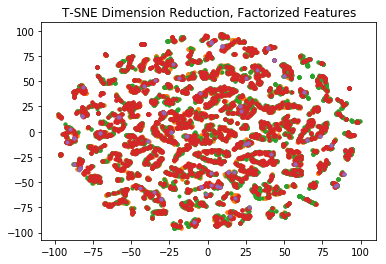

In [4]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

p = 30

X = TSNE(perplexity=p).fit_transform(samp_X)

mask0 = samp_y == 0
mask1 = samp_y == 1
mask2 = samp_y == 2
mask3 = samp_y == 3
mask4 = samp_y == 4
plt.scatter(X[:,0][mask0],X[:,1][mask0],marker='.')
plt.scatter(X[:,0][mask1],X[:,1][mask1],marker='.')
plt.scatter(X[:,0][mask2],X[:,1][mask2],marker='.')
plt.scatter(X[:,0][mask3],X[:,1][mask3],marker='.')
plt.scatter(X[:,0][mask4],X[:,1][mask4],marker='.')
plt.title('T-SNE Dimension Reduction, Factorized Features')
plt.savefig('./images/TSNE1.pdf',bbox_inches='tight')
plt.show()

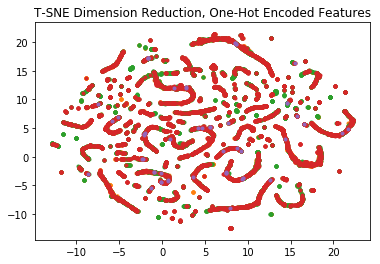

In [5]:
samp = df.sample(20000).copy()
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
gender = pd.get_dummies(samp.GENDER).drop('F',axis=1)
offense = pd.get_dummies(samp.OFFENSE).drop('POSSESSION OF NARCOTICS',axis=1)
det = pd.get_dummies(samp.DETAINER).drop('IMMIGRATION',axis=1)
fac = pd.get_dummies(samp.FACILITY).drop('MACDOUGALL',axis=1)
samp_y = samp.RACE
samp_X = pd.concat(
    [
        samp[['AGE','SENTENCE DAYS']],
        gender, offense, det, fac
    ], axis = 1
) 

p = 30


reducer = umap.UMAP()
X = reducer.fit_transform(samp_X)

mask0 = samp_y == 0
mask1 = samp_y == 1
mask2 = samp_y == 2
mask3 = samp_y == 3
mask4 = samp_y == 4
plt.scatter(X[:,0][mask0],X[:,1][mask0],marker='.')
plt.scatter(X[:,0][mask1],X[:,1][mask1],marker='.')
plt.scatter(X[:,0][mask2],X[:,1][mask2],marker='.')
plt.scatter(X[:,0][mask3],X[:,1][mask3],marker='.')
plt.scatter(X[:,0][mask4],X[:,1][mask4],marker='.')
plt.title('T-SNE Dimension Reduction, One-Hot Encoded Features')
plt.savefig('./images/TSNE2.pdf',bbox_inches='tight')
plt.show()

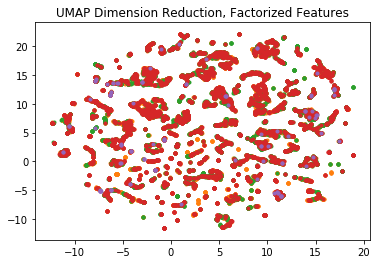

In [6]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

reducer = umap.UMAP()
X = reducer.fit_transform(samp_X)


mask0 = samp_y == 0
mask1 = samp_y == 1
mask2 = samp_y == 2
mask3 = samp_y == 3
mask4 = samp_y == 4
plt.scatter(X[:,0][mask0],X[:,1][mask0],marker='.')
plt.scatter(X[:,0][mask1],X[:,1][mask1],marker='.')
plt.scatter(X[:,0][mask2],X[:,1][mask2],marker='.')
plt.scatter(X[:,0][mask3],X[:,1][mask3],marker='.')
plt.scatter(X[:,0][mask4],X[:,1][mask4],marker='.')
plt.title('UMAP Dimension Reduction, Factorized Features')
plt.savefig('./images/UMAP1.pdf',bbox_inches='tight')
plt.show()

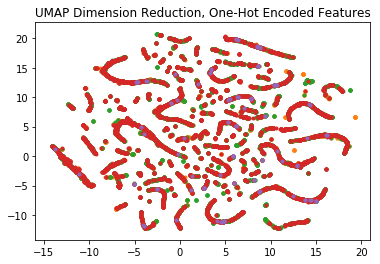

In [7]:
samp = df.sample(20000).copy()
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
gender = pd.get_dummies(samp.GENDER).drop('F',axis=1)
offense = pd.get_dummies(samp.OFFENSE).drop('POSSESSION OF NARCOTICS',axis=1)
det = pd.get_dummies(samp.DETAINER).drop('IMMIGRATION',axis=1)
fac = pd.get_dummies(samp.FACILITY).drop('MACDOUGALL',axis=1)
samp_y = samp.RACE
samp_X = pd.concat(
    [
        samp[['AGE','SENTENCE DAYS']],
        gender, offense, det, fac
    ], axis = 1
) 

reducer = umap.UMAP()
X = reducer.fit_transform(samp_X)


mask0 = samp_y == 0
mask1 = samp_y == 1
mask2 = samp_y == 2
mask3 = samp_y == 3
mask4 = samp_y == 4
plt.scatter(X[:,0][mask0],X[:,1][mask0],marker='.')
plt.scatter(X[:,0][mask1],X[:,1][mask1],marker='.')
plt.scatter(X[:,0][mask2],X[:,1][mask2],marker='.')
plt.scatter(X[:,0][mask3],X[:,1][mask3],marker='.')
plt.scatter(X[:,0][mask4],X[:,1][mask4],marker='.')
plt.title('UMAP Dimension Reduction, One-Hot Encoded Features')
plt.savefig('./images/UMAP2.pdf',bbox_inches='tight')
plt.show()

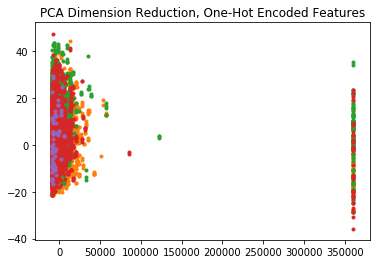

In [8]:
samp = df.sample(20000).copy()
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
gender = pd.get_dummies(samp.GENDER).drop('F',axis=1)
offense = pd.get_dummies(samp.OFFENSE).drop('POSSESSION OF NARCOTICS',axis=1)
det = pd.get_dummies(samp.DETAINER).drop('IMMIGRATION',axis=1)
fac = pd.get_dummies(samp.FACILITY).drop('MACDOUGALL',axis=1)
samp_y = samp.RACE
samp_X = pd.concat(
    [
        samp[['AGE','SENTENCE DAYS']],
        gender, offense, det, fac
    ], axis = 1
) 
pca = PCA(2)
X = pca.fit_transform(samp_X)


mask0 = samp_y == 0
mask1 = samp_y == 1
mask2 = samp_y == 2
mask3 = samp_y == 3
mask4 = samp_y == 4
plt.scatter(X[:,0][mask0],X[:,1][mask0],marker='.')
plt.scatter(X[:,0][mask1],X[:,1][mask1],marker='.')
plt.scatter(X[:,0][mask2],X[:,1][mask2],marker='.')
plt.scatter(X[:,0][mask3],X[:,1][mask3],marker='.')
plt.scatter(X[:,0][mask4],X[:,1][mask4],marker='.')
plt.title('PCA Dimension Reduction, One-Hot Encoded Features')
plt.savefig('./images/PCA.pdf',bbox_inches='tight')
plt.show()

This is only a small sample of things that I tried to do to get useful clusterings given the dimension reduction, though it is representitive of the results I found.

## Ensemble Methods
Ensamble methods seemed imediately like the methods that I should be using in this project. I did not intially expect to successfully classify this data, however as I learned about how ensamble classifiers worked I became more confident that I would get decent results.

The primary reason that I though I would not get good results has to do with how I identified racial bias in the data. In my previous project I determined that there was racial bias in the criminal justice system based on the kurtosis of the distribution of sentence lenghts, when you block inmates by race. Interpreted this means that minorities are much more likely to receive an extreme sentence length than a white person is. This condition is very subtle and I did not think that it would be easily detectable by machine learning methods. However, ensamble methods only need each member to do slightly better than random, so there was hope that I could get good results with these methods.

The methods that I attempted were the following: random forrest classifier, gradient descent boosted classifier, XGBoost, and LightGBM. 

In [23]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

param_grid = {
    'n_estimators': np.arange(100,5100,500),
    'max_depth': np.arange(5,100,10)
}



clf = RandomForestClassifier(oob_score=True)

s = time.time()
clf = GridSearchCV(clf, param_grid, scoring=None, cv=5)
clf = clf.fit(samp_X, samp_y)
e = time.time()
print(f'time to train is {(e-s)/60} minutes')

with open('./pickles/RandomForest_fitted_grid.pickle', "wb+") as f:
    pickle.dump(clf, f)


clf = clf.best_estimator_
clf = clf.fit(samp_X, samp_y)
# print(f'oob score is {clf.oob_score_}')

with open('./pickles/RandomForestClf.pickle', "wb+") as f:
    pickle.dump(clf, f)

In [10]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

In [ ]:
param_grid = {
    'learning_rate': np.linspace(.01,1,5),
    'subsample': np.linspace(.05,1,5)
}

clf = GradientBoostingClassifier(n_estimators=1000, max_depth=85)

s = time.time()
clf = GridSearchCV(clf, param_grid, cv=5)
clf = clf.fit(samp_X, samp_y)
e = time.time()

with open('./pickles/GB_fitted_grid1.pickle', "wb+") as f:
    pickle.dump(clf, f)

clf = clf.best_estimator_
clf = clf.fit(samp_X, samp_y)

print(f'time is {(e-s)/60}')

with open('./pickles/GradientBoostedClf1.pickle', "wb+") as f:
    pickle.dump(clf, f)

In [33]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

In [ ]:
param_grid = {
    'reg_alpha':np.linspace(.01,1,10),
    'reg_lambda':np.linspace(.01,1,10),
    'gamma':np.linspace(.01,1,10)
}

clf = xgboost.XGBClassifier(learning_rate=1)
s = time.time()
clf = GridSearchCV(clf, param_grid,cv=5)
clf = clf.fit(samp_X, samp_y)

with open('./pickles/XBG_fitted_grid.pickle', 'wb+') as f:
    pickle.dump(clf, f)

clf = clf.best_estimator_
clf = clf.fit(samp_X, samp_y)
e = time.time()

# print(f'time was {(e-s)/(60*60)} hours')

with open('./pickles/XGBoostClf.pickle', 'wb+') as f:
    pickle.dump(clf, f)

### LightGBM

LightGBM is an attempt to improve upon the efficiency, both temporally and spatially, of different grandient boosted decision tree (GBDT) algorithms such as XGBoost. This algoritm was developed by a team at Microsoft and it uses two novel techniques to imporove GBDT algorithms. The baseline comparison used was against XGBoost, since the team found this method to be the best performer of the commonly used GBDT algorithms.

By analyzing GBDT algorithms the team found that the most expensive parts of the process is learning the decision trees and the most expensive part of learning the decision trees is finding the best split points. They decided to use a histogram based approach for efficiency. This process is dominated by the histogram building which has a complexity of $O(\#data \times \#feature)$. Now the goal is to reduce the feature number or the number of data points.

#### Gradient-based One-Side Sampling
This is the first novel technique proposed by the Microsoft team. It is a sampling method that is meant to reduce the number of data instances while maintaing accuracy. The main idea here is that data points with small gradient are usually ignored, since the model is already will trained on those data instances. However, the changes that occur by ignoring the data will small gradient may reduce the accuracy of the model once it is learned. Therefore GOSS examines all of the high gradient data and a random sample of the small gradient data. This method can maximize the amount of relevent data used in the training of the model without handicapping the accuracy completely.

#### Exclusive Feature Bundling
This is the second novel technique and its goal is to reduce the number of features. This technique relies on the fact that high dimensional data tend to be sparse, and therefore there are likely large bundles of features that are mutually exclusive are nearly mutually exclusive. These features can be bundled into a single feature and their histograms can be combined. This reduces the complexity of building histograms from $O(\#data \times \#feature)$ to $O(\#data \times \#bundle)$ and if $\#bundle << \#feature$ then the total complexity is greatly reduced.

In [ ]:
samp = df.sample(20000)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]
with open('./pickles/LGBM_fitted_grid.pickle',"rb") as f:
    clf = pickle.load(f)
    
    clf = clf.best_estimator_
    clf = clf.fit(samp_X,samp_y)

with open('./pickles/LGBMClf.pickle', 'wb+') as f:
    pickle.dump(clf, f)

# Results

## Random Forest Classifier
The random forest classifier was an easy place to begin in my attempt to find a successful classifier. It is a simple method and would likely give me a good lower bound on the success that I would have.

In using the random forest classifier I did a gridsearch for the best parameters. The parameters I decided to seach over are the number of trees in the classifier and the maximum depth of the trees in the classifier. I chose this because having more trees in the classifier will improve the accuracy, however if the depth of each of the trees in unbounded then overfitting of the individual trees may become an issue.

In my gridsearch I found the best parameters to be the following

In [ ]:
with open('./pickles/RandomForestClf.pickle',"rb") as f:
    clf = pickle.load(f)
    print('Max Depth = {}'.format(clf.get_params()['max_depth']))
    print('Number of Estimators = {}.'.format(clf.get_params()['n_estimators']))

My results with the random forest classifier were rather disappointing, especially given the amount of time it took to train which was 5.32 hours on the following parameter grid 

```python
param_grid = {
    'n_estimators': np.arange(100,5100,500),
    'max_depth': np.arange(5,100,10)
}
```

which amounts to a 100 parameter grid.

The out-of-box score was rather promising at .70 however the method scored barely better than chance. Here is a scoring of the model I ran:

In [17]:
size = 500000
samp = df.sample(size)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]
clf.score(samp_X,samp_y)

with open('./pickles/RandomForestClf.pickle',"rb") as f:
    clf = pickle.load(f)
    score = clf.score(samp_X,samp_y)
    print(f'score on a test size of {size} is {score}.')

/home/ethan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ethan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


score on a test size of 500000 is 0.286044


The scoring here is lackluster to say the least though it did give me hope for more complex methods to preform better.

## Gradient Descent Boosted Classification
This method is an obvious next step after a random forest. With the ability to alter the subsample rate and the learning rate, I expect to get better results with this model. I began by doing another grid search, but I used some of the results from the previous search on the random forest model to save time. Fitting the following grid


```python
param_grid = {
    'learning_rate': np.linspace(.01,1,5),
    'subsample': np.linspace(.05,1,5)
}
```

I found the following parameters

In [ ]:
with open('./pickles/GradientBoostedClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    print('Max Depth = {}'.format(clf.get_params()['max_depth']))
    print('Number of Estimators = {}.'.format(clf.get_params()['n_estimators']))

The model scored slightly better than the random forest model, as expected giving the following score:

In [ ]:
size = 5000000
samp = df.sample(size)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

with open('./pickles/GradientBoostedClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    score = clf.score(samp_X,samp_y)
    print(f'score on a test size of {size} is {score}.')

## XGBoost
XGBoost was the best ensemble classifier of which I was aware when I began this project, so it was the obvious conclusion to my exploration of ensemble classifiers.

The grid I used was the following

```python
param_grid = {
    'reg_alpha':np.linspace(.01,1,10),
    'reg_lambda':np.linspace(.01,1,10),
    'gamma':np.linspace(.01,1,10)
}
```

and I found the following parameters

In [ ]:
with open('./pickles/XGBoostClf.pickle', "rb") as f:
    clf = pickle.load(f)
    params = clf.get_params()
    print('L1 Regularization = {}'.format(clf.get_params()['reg_alpha']))
    print('L2 Regularization = {}.'.format(clf.get_params()['reg_lambda']))
    print('Minimum loss reduction = {}.'.format(clf.get_params()['gamma']))    

XGBoost scores very well compared to the other methods that I used, 

In [ ]:
size = 5000000
samp = df.sample(size)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

with open('./pickles/XGBoostClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    score = clf.score(samp_X,samp_y)
    print(f'score on a test size of {size} is {score}.')

## LightGBM
Because I was very new to LightGBM when I began, I did a grid search on the following grid 

```python
param_grid = {
    'boosting_type': ['gbdt','dart','goss'],
    'learning_rate': np.linspace(.01,1,10),
    'n_estimators': np.arange(100,1100,100),
    'max_depth': np.arange(0,10)
}
```

and I found the following best parameters

In [ ]:
with open('./pickles/LGBMClf.pickle',"rb") as f:
    clf = pickle.load(f)
    print('Boosting Type = {}'.format(clf.get_params()['boosting_type']))
    print('Learning Rate = {}'.format(clf.get_params()['learning_rate']))
    print('Number of Estimators = {}'.format(clf.get_params()['n_estimators']))    
    print('Maximum Depth = {}.'.format(clf.get_params()['max_depth']))    

Note that a max depth <= 0 indicates that the depth is unbounded. Searching over this grid of size 4000 is something that I would have never even tried for XGBoost or any other GBDT method, though it still did take slightly more than 20 hours to fit

After this I did a grid search on the following grid

```python
param_grid = {
    'reg_alpha': np.linspace(.1,1,10),
    'reg_lambda': np.linspace(.1,1,10)
}
```

and found --------

In [ ]:
with open('./pickles/LGBMClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    print('L1 Regularization = {}'.format(clf.get_params()['reg_alpha']))
    print('L2 Regularization = {}'.format(clf.get_params()['reg_lambda']))

LightGBM scored comparible to XGBoost, as expected with what was reported in the paper introducing it

In [ ]:
size = 5000000
samp = df.sample(size)
samp.RACE = pd.factorize(samp['RACE'])[0] + 1
samp.GENDER = pd.factorize(samp['GENDER'])[0] + 1
samp.OFFENSE = pd.factorize(samp['OFFENSE'])[0] + 1
samp.DETAINER = pd.factorize(samp['DETAINER'])[0] + 1
samp.FACILITY = pd.factorize(samp['FACILITY'])[0] + 1
samp_y = samp.RACE
samp_X = samp[['GENDER','AGE','OFFENSE','FACILITY','DETAINER','SENTENCE DAYS']]

with open('./pickles/LGBMClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    score = clf.score(samp_X,samp_y)
    print(f'score on a test size of {size} is {score}.')

## Feature Importances 
The only thing left to report about the results of my research is to examine the different assigned feature importances.
They are as follows:

In [ ]:
with open('./pickles/RandomForestClf.pickle',"rb") as f:
    clf = pickle.load(f)
    imp = clf.feature_importances_
    print('Random Forest:')
    for i in range(len(imp)):
        print(f'\t{features[i]} = {imp[i]}')

with open('./pickles/GradientBoostedClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    imp = clf.feature_importances_
    print('Gradient Boosted Classifier:')
    for i in range(len(imp)):
        print(f'\t{features[i]} = {imp[i]}')
        
with open('./pickles/XGBoostClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    imp = clf.feature_importances_
    print('XGBoost:')
    for i in range(len(imp)):
        print(f'\t{features[i]} = {imp[i]}')
        
with open('./pickles/LGBMClf1.pickle',"rb") as f:
    clf = pickle.load(f)
    imp = clf.feature_importances_
    print('LightGBM:')
    for i in range(len(imp)):
        print(f'\t{features[i]} = {imp[i]}')


# Analysis


# Conclusion


# References
[[1]](https://www.aclu.org/other/statement-concern-about-predictive-policing-aclu-and-16-civil-rights-privacy-racial-justice) Statement Of Concern About Predictive Policing By Aclu and 16 Civil Rights Privacy, Racial Justice, and Technology Organizations
https://www.aclu.org/other/statement-concern-about-predictive-policing-aclu-and-16-civil-rights-privacy-racial-justice


[[2]](http://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf) Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., … Liu, T.-Y. (2017). LightGBM: A Highly Efficient Gradient Boosting Decision Tree. Advances in Neural Information Processing Systems 30 (NIPS 2017). Retrieved from http://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf